In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

# Birth & Death

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
special_probs = {"birth": 0.5, "death": 0.5}
#special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

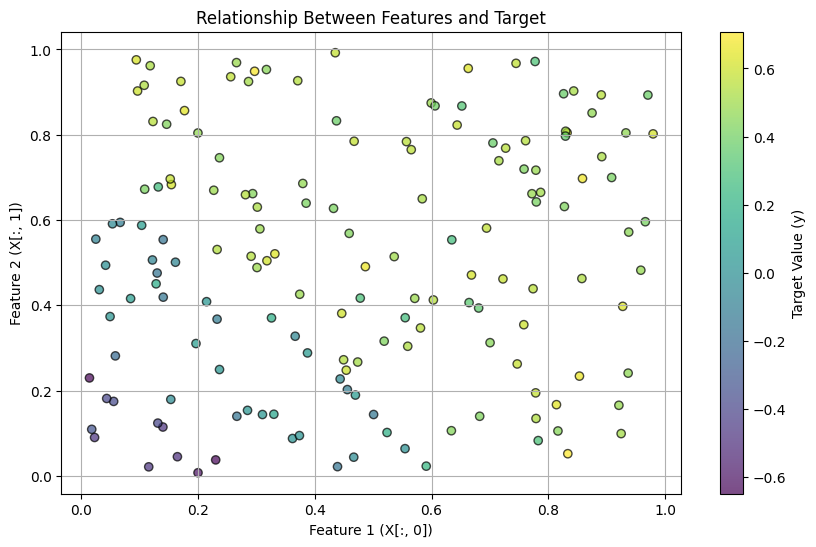

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
bart = ChangeNumTreeBART(ndpost=10000, nskip=0, n_trees=100, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 100, theta_df = np.inf, 
                         tree_num_prior_type="poisson")
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 10000/10000 [02:20<00:00, 71.33it/s]


In [5]:
bart.trace[-1].n_trees

2

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.01383855]), 'ntree_theta': 100}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

22.576842315768424

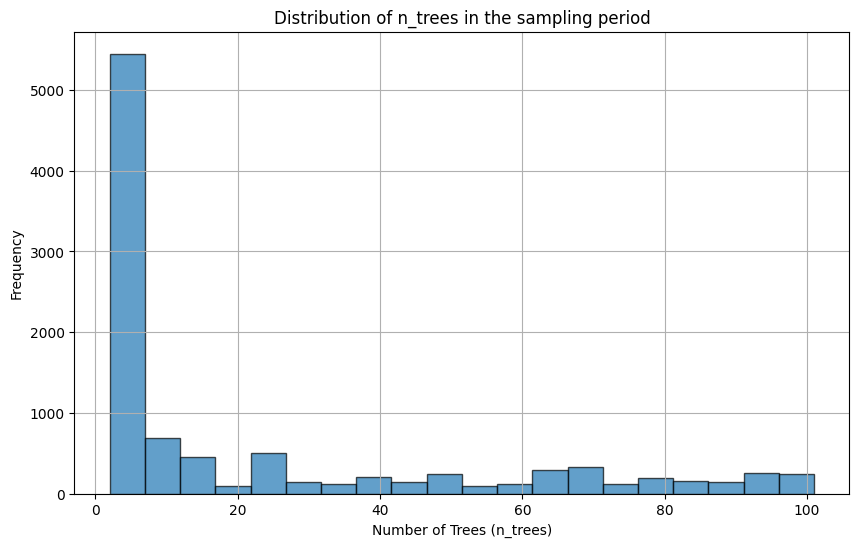

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

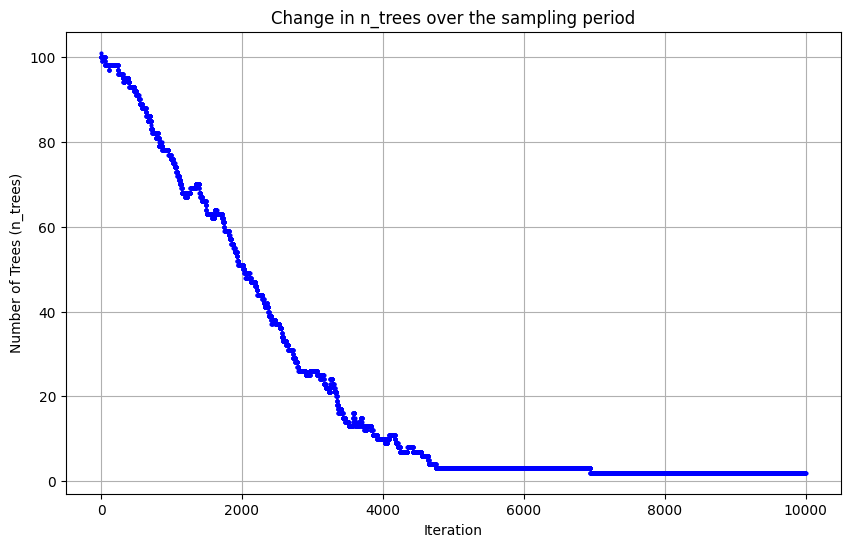

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 5024; mh median: 9.086684222705722e-17


In [11]:
print(f'Birth move likelihood median: {np.median(bart.sampler.birth_likelihood_ratios)}')

Birth move likelihood median: 1.173557993337002e-16


In [12]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 137; mh median: 26.933407377102377


In [13]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-04-16 20:01:12,534:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-16 20:01:12,564:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.00 P_prune=1.00 A_grow=nan A_prune=0.50 (burnin)
Iteration 200/300 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration 300/300 P_grow=0.00 P_prune=1.00 A_grow=nan A_prune=0.00


In [14]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.038970693516561475,
 'rf': 0.03681606813499092,
 'lr': 0.048045521328019404,
 'btz': 0.031405507956514866}

In [15]:
bart.trace[-1].trees

[Tree(vars=[ 0  1 -1 -1 -1 -2 -2 -2], thresholds=[0.44836788 0.23520508        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan  0.27210419 -0.0162989   0.26783946         nan
          nan         nan], n_vals=[120  61  59  15  46  -2  -2  -2]),
 Tree(vars=[ 0  1  0  0 -1 -1 -1 -1 -1 -2 -2 -2 -2 -2 -2 -2], thresholds=[0.8585056  0.60854907 0.91452779 0.23257914        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan], leaf_vals=[        nan         nan         nan         nan  0.0962758   0.12001656
   0.11307911 -0.33391882  0.0244603          nan         nan         nan
          nan         nan         nan         nan], n_vals=[120 106  14  65  41   4  10  22  43  -2  -2  -2  -2  -2  -2  -2])]